## imports & environ

In [1]:
from datetime import datetime
import random
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
sns.set_theme(rc={'figure.figsize':(16,8)})

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# functions

## def get_X_y()

In [3]:
# The main data selection function. 
# This function will generate all random slices based on the length of the dataframe passed. 
# Important to note, if val state is set to true, it will only generate data slices after the val_cutoff point.

In [4]:
def get_X_y(df, 
            X_length=56, 
            y_length=7, 
            number_of_sequences=51, 
            number_of_targets=4, 
            val=False, 
            val_cutoff=0.8):


#     limit dataframes to length for train/test splits
    df_X = df.copy()
    df_y = df.iloc[:, :number_of_targets].copy()
    
#     convert and scale X dataframe to PCA to solve dimensionality problem
    scaler = MinMaxScaler()
    df_X_scaled = pd.DataFrame(scaler.fit_transform(df_X), columns=df_X.columns, index=df_X.index)
    
#     create unique list to sample random datapoints from
    if val:
        sample_list = list(range(int(len(df_y)*val_cutoff), int(len(df_y)-y_length)))
    if not val:
        sample_list = list(range(int(X_length), int(len(df_y)-y_length)))
    random.shuffle(sample_list)
    
#     empty lists to append data to, will create 3D dataframe here
    X, y = [], []
    
    
    
#     define a simple data slicing and selection function. This function will create a slice of data from a specified random starting position. The random position must be generated externally.
    
    def get_Xi_yi(df_X, 
              df_y,
              random_start,
              X_length, 
              y_length):
    
#     must define a random_start:int for function to run
        Xi = df_X.iloc[random_start-X_length:random_start]
        yi = df_y.iloc[random_start:random_start+y_length]

        return Xi, yi

    
#     for loop to select ith values from data
    for i in range(number_of_sequences):
        Xi, yi = get_Xi_yi(df_X_scaled, df_y, sample_list.pop(), X_length, y_length)
        X.append(Xi.values.tolist())
        y.append(yi.values.tolist())
        
    return np.array(X), np.array(y)


# load df_main

In [5]:
df_main = pd.read_csv('socio_test_data.csv')
df_main['date'] = pd.to_datetime(df_main['date'])
df_main = df_main.set_index('date')
# df_main = df_main.fillna(-1)

In [6]:
df_main.head()

,SPY_open,SPY_high,SPY_low,SPY_close,QQQ_open,QQQ_high,QQQ_low,QQQ_close,GLD_open,GLD_high,GLD_low,GLD_close,real_gdp,cpi,inflation
date,,,,,,,,,,,,,,,
1993-01-29,25.140213,25.140213,25.015137,25.122345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-01-30,25.140214,25.193818,25.056830,25.181906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-01-31,25.140215,25.247423,25.098523,25.241467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,25.140216,25.301027,25.140216,25.301027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.100000,NaN
1993-02-02,25.283158,25.372497,25.229554,25.354630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.117857,NaN


In [7]:
df_main = df_main.loc['2015-01-01':]

In [8]:
df_main.head(1)

,SPY_open,SPY_high,SPY_low,SPY_close,QQQ_open,QQQ_high,QQQ_low,QQQ_close,GLD_open,GLD_high,GLD_low,GLD_close,real_gdp,cpi,inflation
date,,,,,,,,,,,,,,,
2015-01-01,178.299201,178.600402,176.233801,176.836205,97.457979,97.855747,96.185119,96.489296,113.689999,114.900002,112.799999,113.830002,4212.523,233.707,0.118627


In [9]:
df_main.tail()

,SPY_open,SPY_high,SPY_low,SPY_close,QQQ_open,QQQ_high,QQQ_low,QQQ_close,GLD_open,GLD_high,GLD_low,GLD_close,real_gdp,cpi,inflation
date,,,,,,,,,,,,,,,
2023-05-19,420.170013,420.720001,417.350006,418.619995,337.489990,338.209991,335.429993,336.510010,182.250000,184.339996,181.809998,183.639999,4946.8,303.363,8.0028
2023-05-20,419.660014,420.610006,417.350006,418.676666,337.076660,338.363332,335.699992,336.886678,182.573334,184.173330,182.176666,183.496668,4946.8,303.363,8.0028
2023-05-21,419.150014,420.500010,417.350006,418.733337,336.663330,338.516673,335.969991,337.263346,182.896667,184.006663,182.543335,183.353338,4946.8,303.363,8.0028
2023-05-22,418.640015,420.390015,417.350006,418.790009,336.250000,338.670013,336.239990,337.640015,183.220001,183.839996,182.910004,183.210007,4946.8,303.363,8.0028
2023-05-23,417.079987,418.721985,416.839996,417.830109,335.890015,337.059998,335.709991,336.589996,182.779999,183.345001,182.479996,182.819000,4946.8,303.363,8.0028


In [10]:
df_main.shape

(3065, 15)

In [11]:
df_main.columns

Index(['SPY_open', 'SPY_high', 'SPY_low', 'SPY_close', 'QQQ_open', 'QQQ_high',
       'QQQ_low', 'QQQ_close', 'GLD_open', 'GLD_high', 'GLD_low', 'GLD_close',
       'real_gdp', 'cpi', 'inflation'],
      dtype='object')

# X, y

## define X_train, y_train

In [12]:
### SPECIFY HOW MANY PRIOR YEARS TO TRAIN WITH HERE ###

In [13]:
X_train, y_train = get_X_y(df_main.iloc[:int(len(df_main)*0.9)], 
                           X_length=56, 
                           y_length=7, 
                           number_of_sequences=365*5, 
                           number_of_targets=4)

In [14]:
# select your target here (open, high, low, close)
# selecting OPEN for trials
y_train = y_train[:, :, 0]

In [ ]:
y

In [15]:
print(X_train.shape, y_train.shape)

(1825, 56, 15) (1825, 7)


## X_val, y_val

In [16]:
X_val, y_val = get_X_y(df_main.iloc[:int(len(df_main)*0.99)], 
                       X_length=56, 
                       y_length=7, 
                       number_of_sequences=260, 
                       number_of_targets=4, 
                       val=True, 
                       val_cutoff=0.9)

In [17]:
# select your target here (open, high, low, close)
# selecting OPEN for trials
y_val = y_val[:, :, 0]

In [18]:
print(X_val.shape, y_val.shape)

(260, 56, 15) (260, 7)


## X_test, y_test

In [19]:
X_test, y_test = get_X_y(df_main, 
                         X_length=56, 
                         y_length=7, 
                         number_of_sequences=10, 
                         number_of_targets=4, 
                         val=True, 
                         val_cutoff=0.99)

In [20]:
# select your target here (open, high, low, close)
# selecting OPEN for trials
y_test = y_test[:, :, 0]

In [21]:
print(X_test.shape, y_test.shape)

(10, 56, 15) (10, 7)


# target scaling

## y_scaler

In [22]:
# y normalize
y_scaler = MinMaxScaler()
y_scaler.fit(np.log(y_train))

y_train_scaled = y_scaler.transform(np.log(y_train))
y_test_scaled = y_scaler.transform(np.log(y_test))
y_val_scaled = y_scaler.transform(np.log(y_val))

# model

## architecture

In [23]:
input_shape = X_train.shape[1:]
output_shape = y_train_scaled.shape[1]
reg = regularizers.l1_l2(l1=0.04, l2=0.02)

In [24]:
# instantiate model
model = Sequential()

# hidden layer architecture
model.add(LSTM(200, return_sequences=True, input_shape = input_shape))

model.add(LSTM(150, return_sequences=True, recurrent_regularizer=reg))

model.add(LSTM(150, return_sequences=True, recurrent_regularizer=reg))

model.add(LSTM(150, return_sequences=True, recurrent_regularizer=reg))

# pass final sequences
model.add(LSTM(200, return_sequences=False))

# prediction layer
model.add(Dense(output_shape, activation = 'linear'))

Metal device set to: Apple M1 Max


In [25]:
# print out model summary for brownie points on website

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 56, 200)           172800    
                                                                 
 lstm_1 (LSTM)               (None, 56, 150)           210600    
                                                                 
 lstm_2 (LSTM)               (None, 56, 150)           180600    
                                                                 
 lstm_3 (LSTM)               (None, 56, 150)           180600    
                                                                 
 lstm_4 (LSTM)               (None, 200)               280800    
                                                                 
 dense (Dense)               (None, 7)                 1407      
                                                                 
Total params: 1,026,807
Trainable params: 1,026,807
Non-

## fit

In [26]:
optimizer = Nadam(learning_rate=0.00003, 
                  beta_1=0.8,
                  epsilon=1e-18)

In [27]:
model.compile(
    loss=['mae'], 
    metrics=['mae'],
    optimizer=optimizer
)

es = EarlyStopping(
    patience=5, 
    restore_best_weights=True
)

history = model.fit(
                X_train, 
                y_train_scaled, 
                batch_size = 16, 
                epochs = 30,
                shuffle = False,
                verbose = 2,
                validation_data = (X_val, y_val_scaled), 
                callbacks=[es]
)

Epoch 1/30
115/115 - 16s - loss: 343.1093 - mae: 0.1543 - val_loss: 324.3414 - val_mae: 0.0359 - 16s/epoch - 142ms/step
Epoch 2/30
115/115 - 9s - loss: 307.1483 - mae: 0.0267 - val_loss: 289.8324 - val_mae: 0.0348 - 9s/epoch - 74ms/step
Epoch 3/30
115/115 - 8s - loss: 273.9255 - mae: 0.0254 - val_loss: 257.9293 - val_mae: 0.0338 - 8s/epoch - 74ms/step
Epoch 4/30
115/115 - 9s - loss: 243.2775 - mae: 0.0246 - val_loss: 228.5728 - val_mae: 0.0336 - 9s/epoch - 74ms/step
Epoch 5/30
115/115 - 9s - loss: 215.1446 - mae: 0.0239 - val_loss: 201.6942 - val_mae: 0.0337 - 9s/epoch - 75ms/step
Epoch 6/30
115/115 - 9s - loss: 189.4596 - mae: 0.0235 - val_loss: 177.2296 - val_mae: 0.0336 - 9s/epoch - 79ms/step
Epoch 7/30
115/115 - 9s - loss: 166.1296 - mae: 0.0231 - val_loss: 155.0490 - val_mae: 0.0339 - 9s/epoch - 76ms/step
Epoch 8/30
115/115 - 9s - loss: 145.0183 - mae: 0.0227 - val_loss: 135.0262 - val_mae: 0.0334 - 9s/epoch - 75ms/step
Epoch 9/30
115/115 - 9s - loss: 126.0124 - mae: 0.0224 - val_

## predict

In [28]:
y_pred = model.predict(X_test)

y_pred = y_scaler.inverse_transform(y_pred)
y_pred = np.exp(y_pred)

1/1 [==============================] - 1s 1s/step


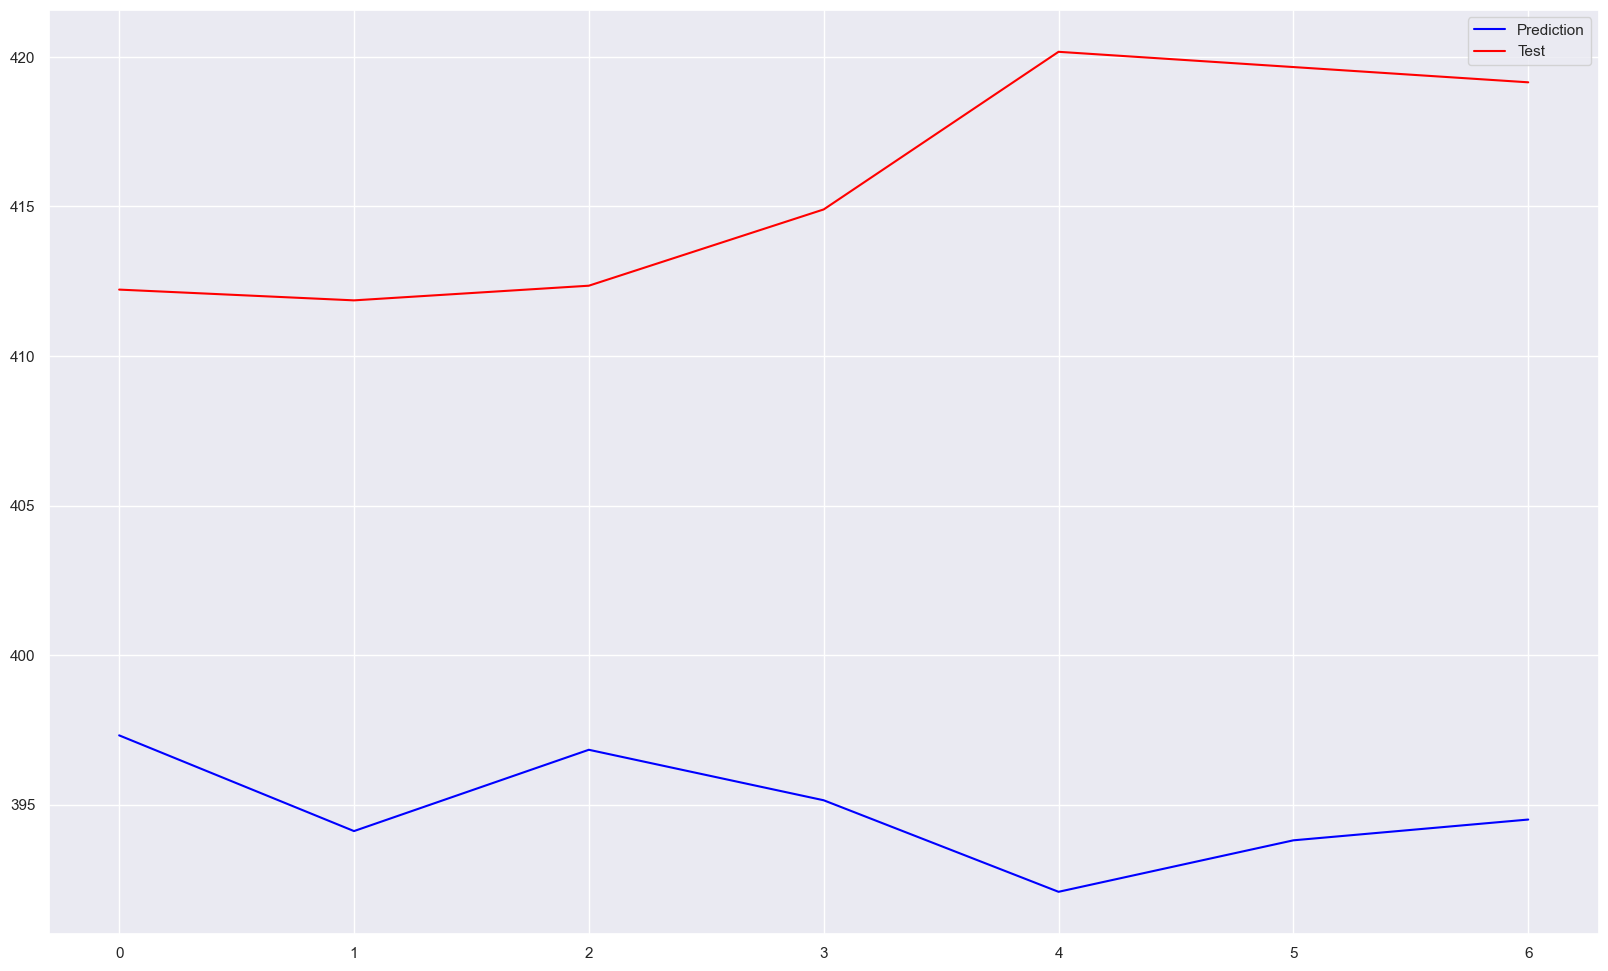

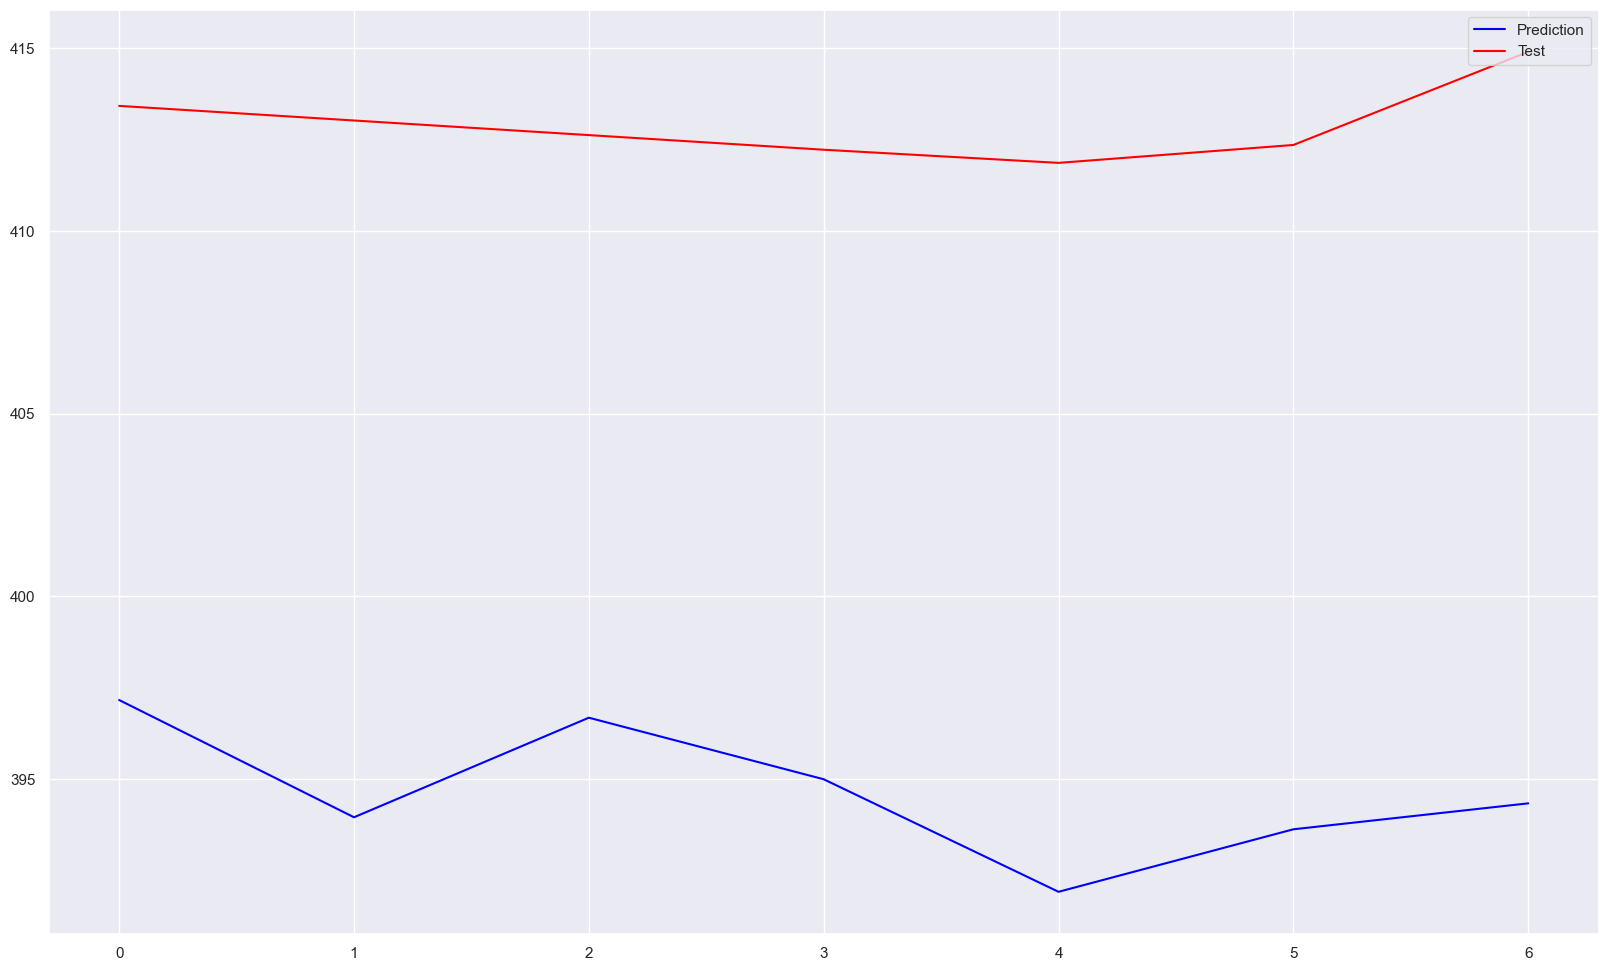

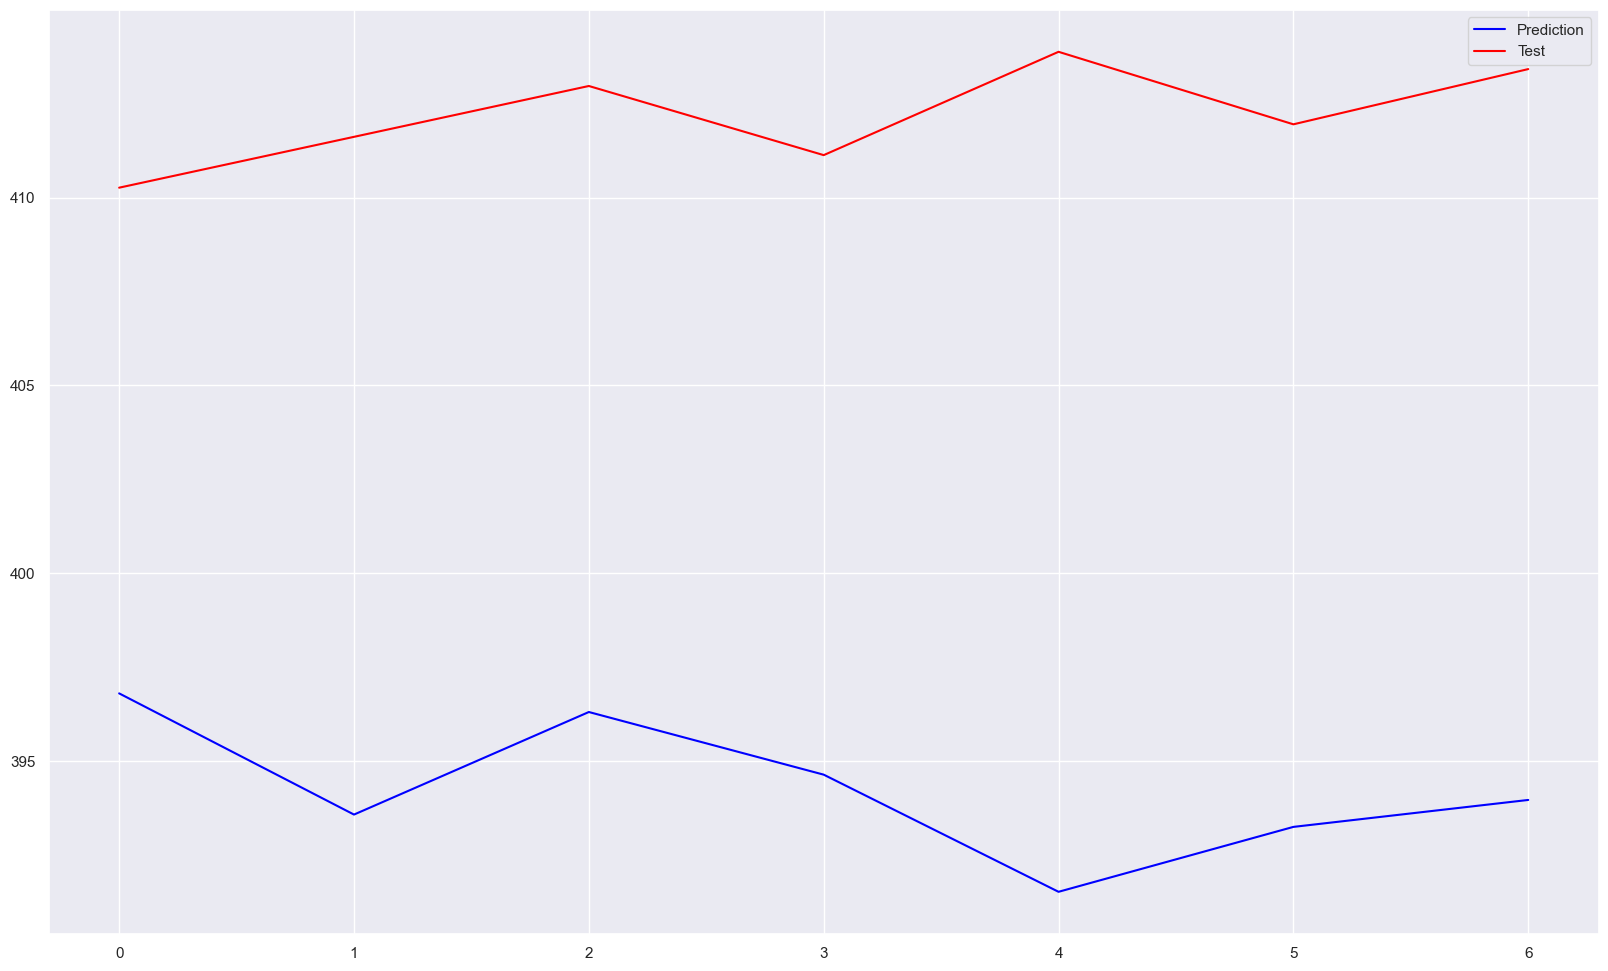

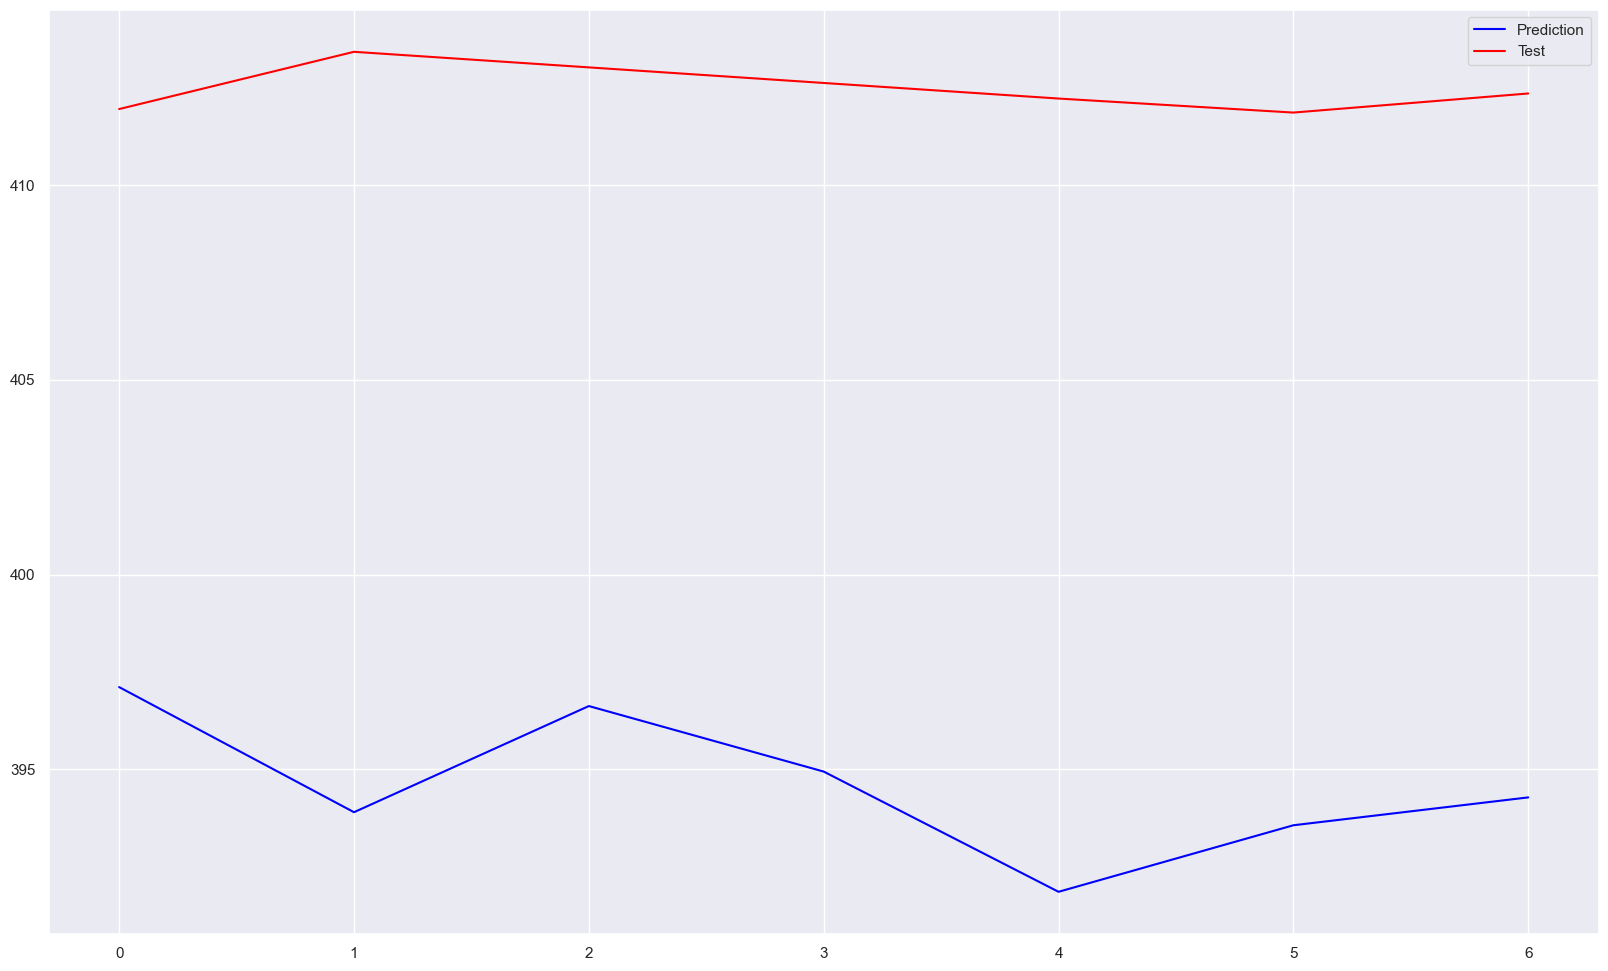

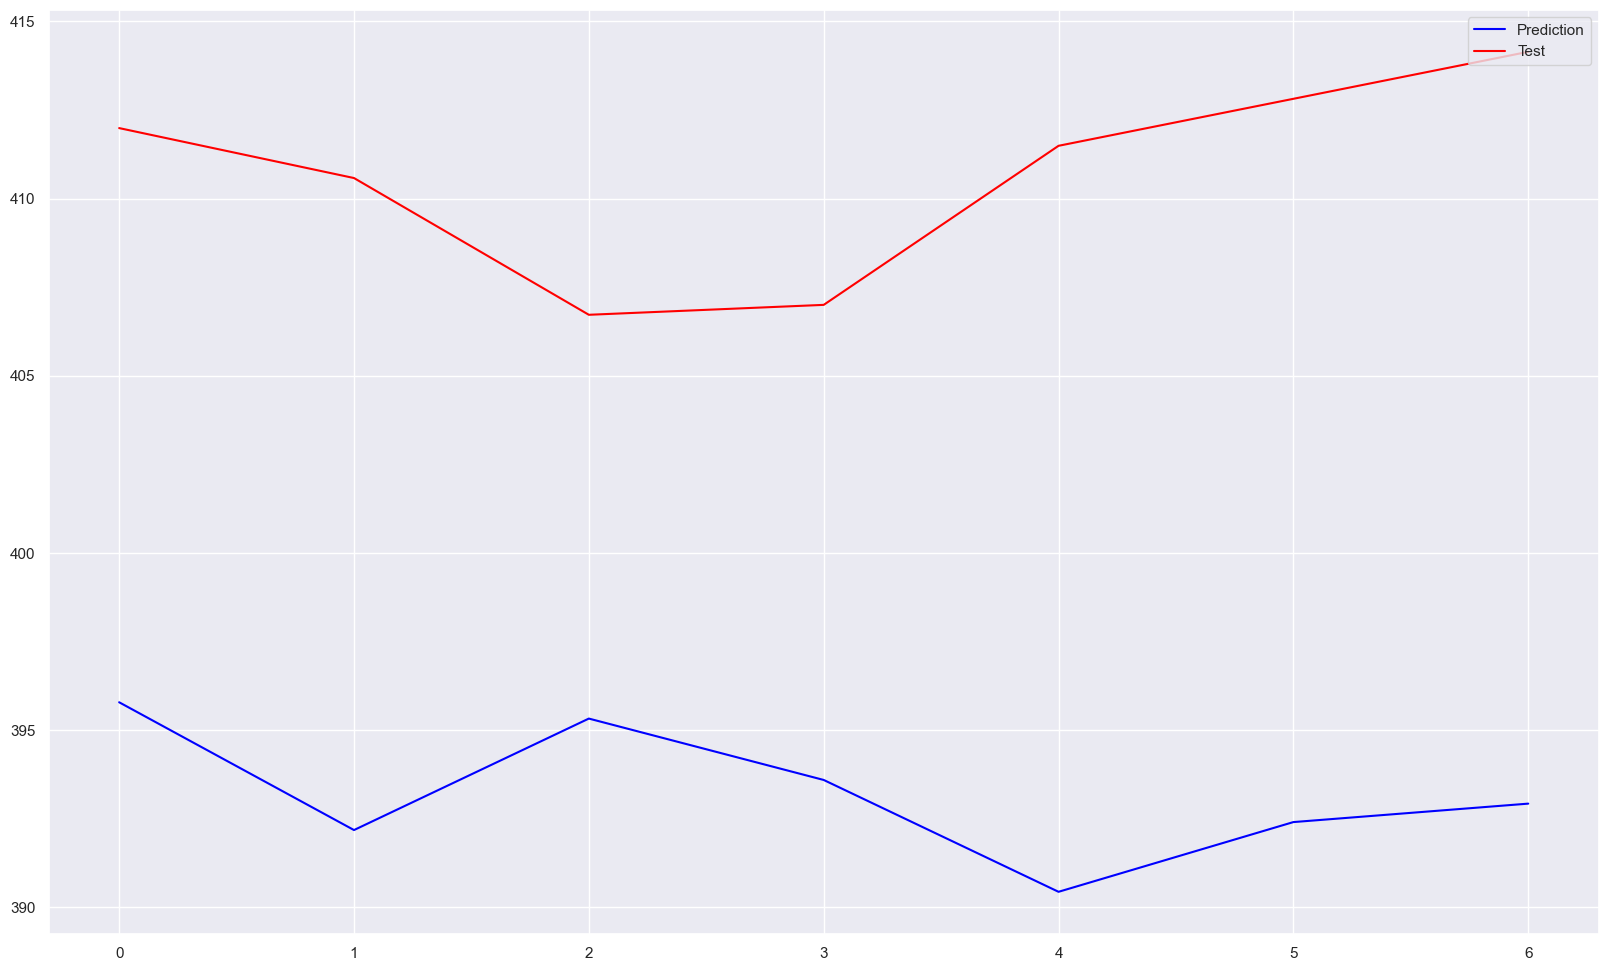

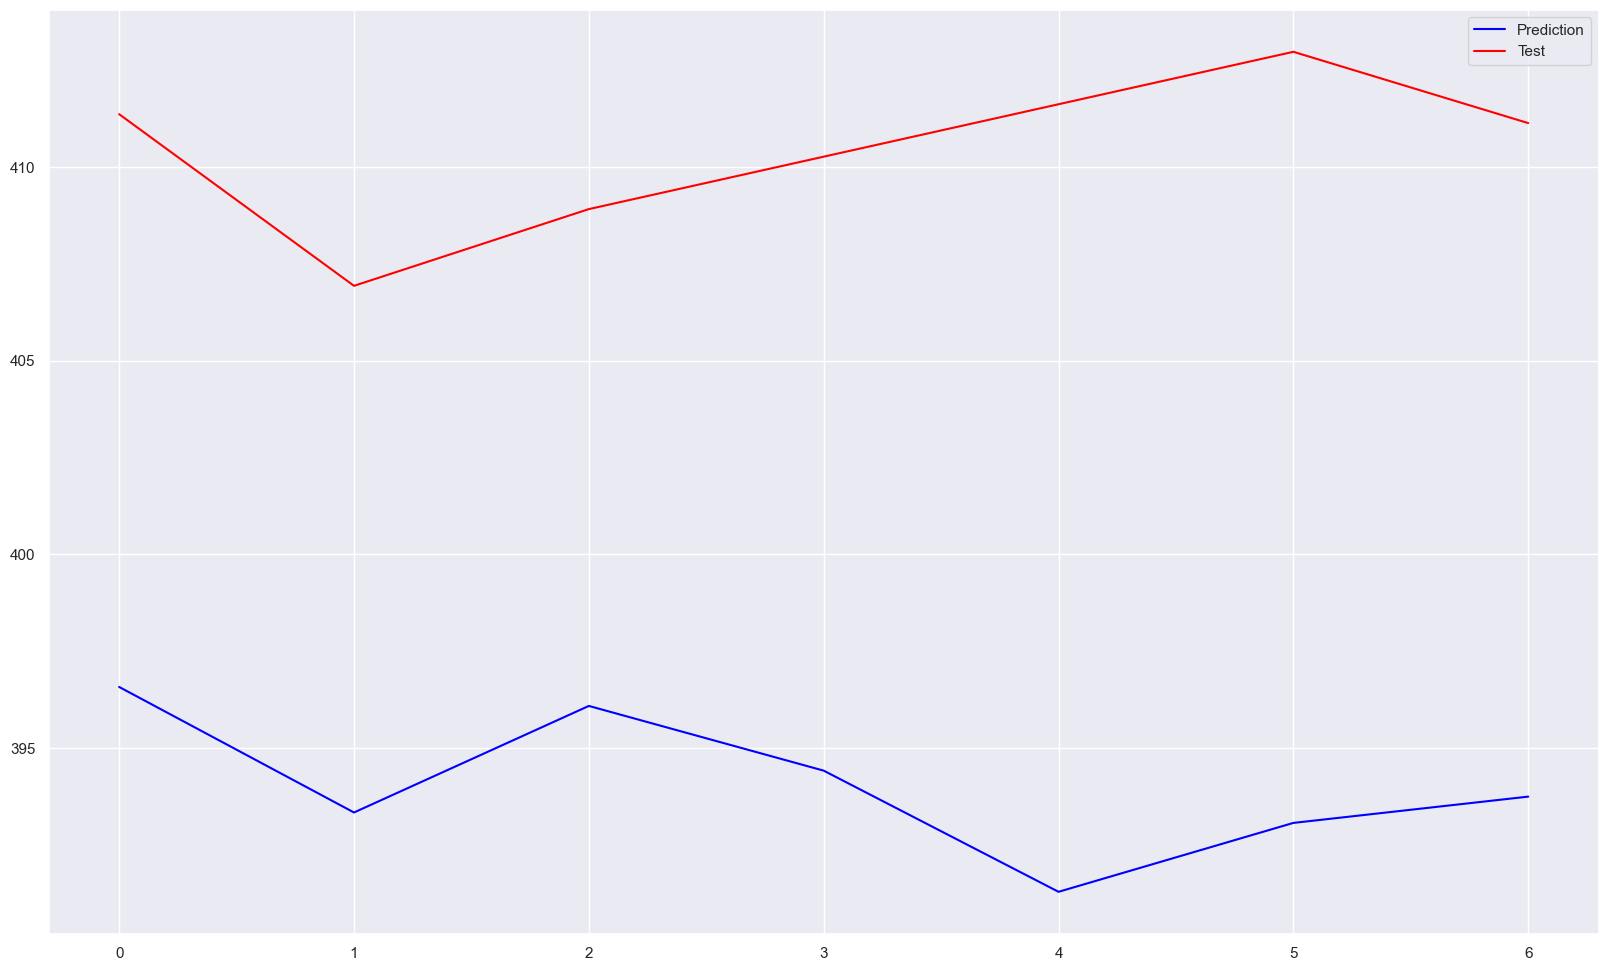

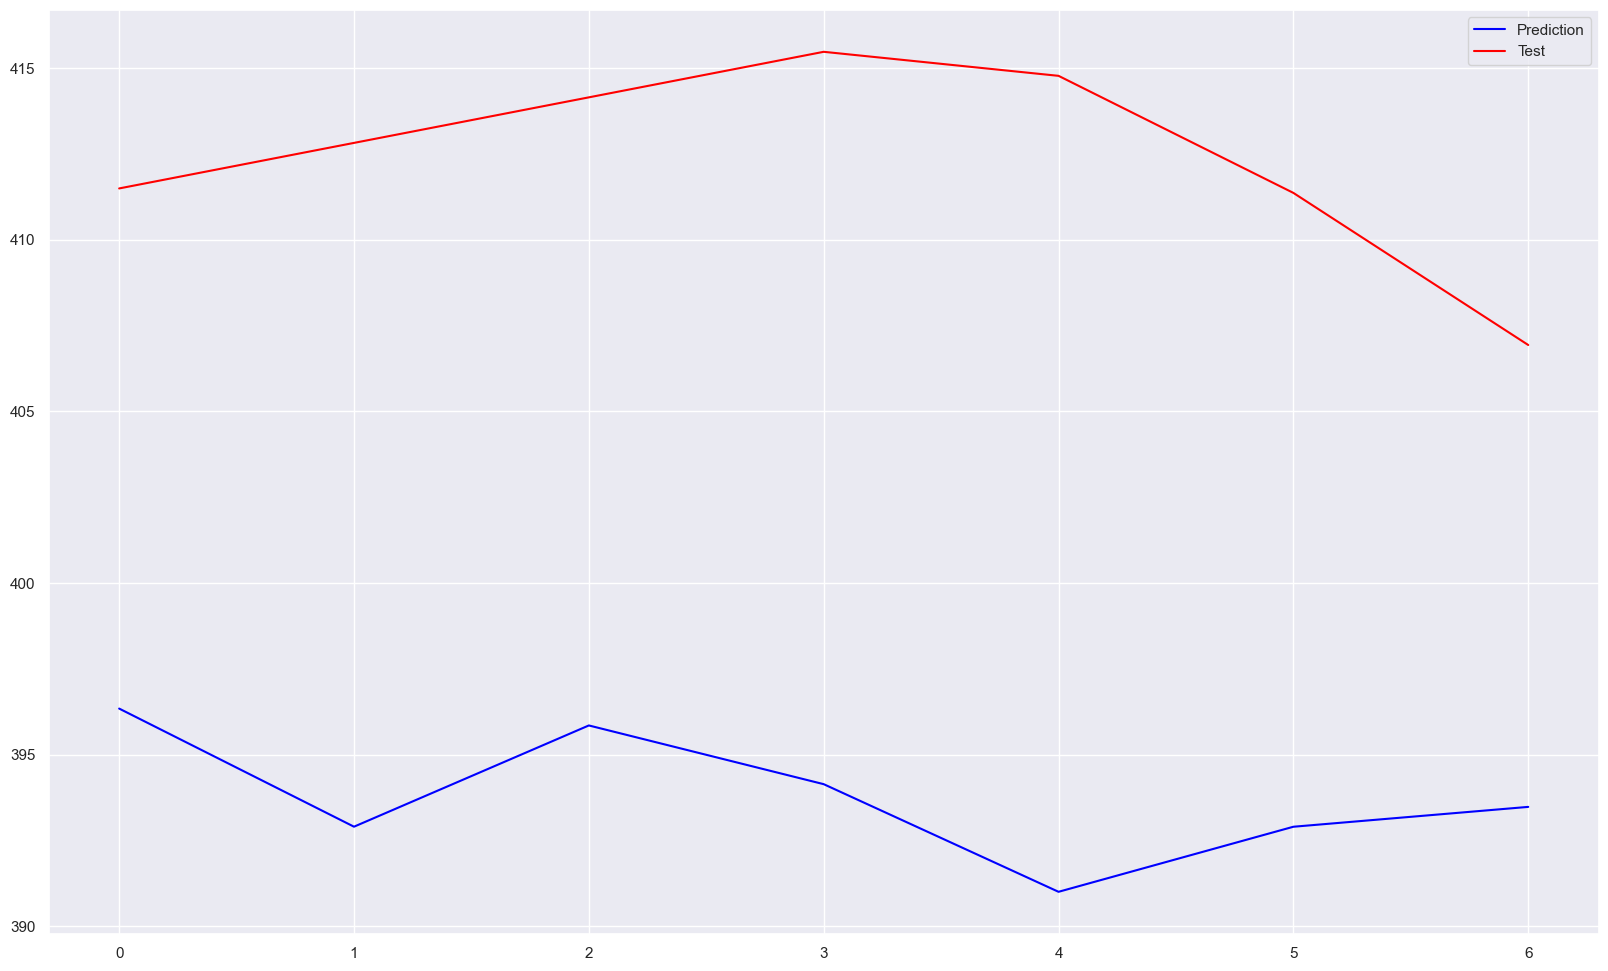

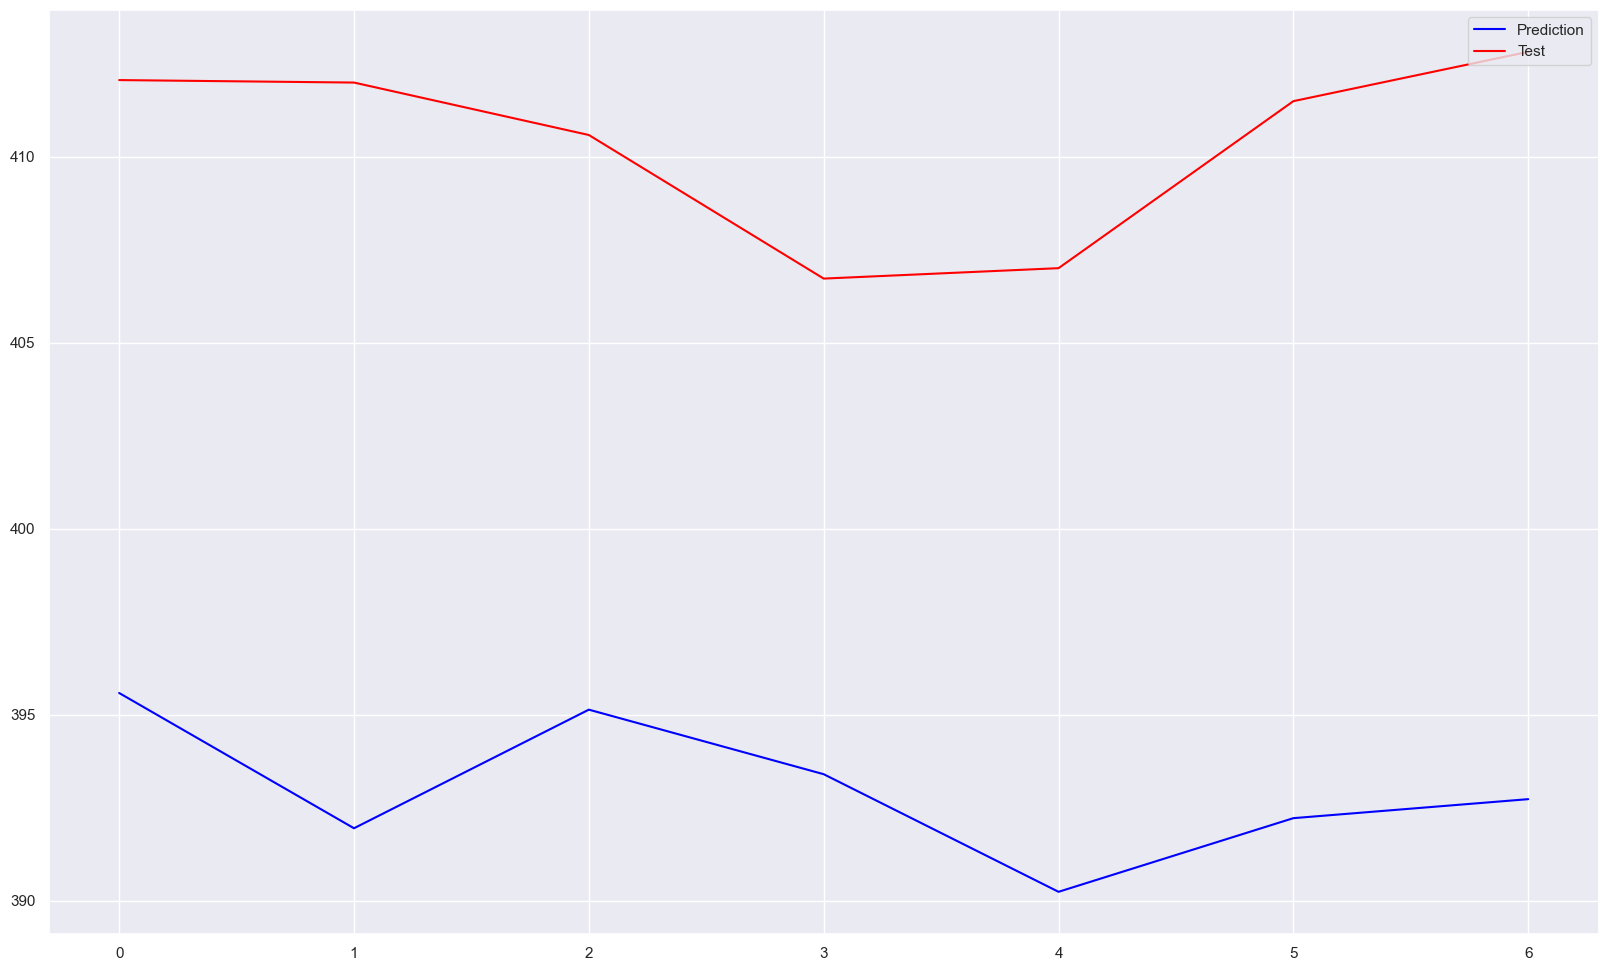

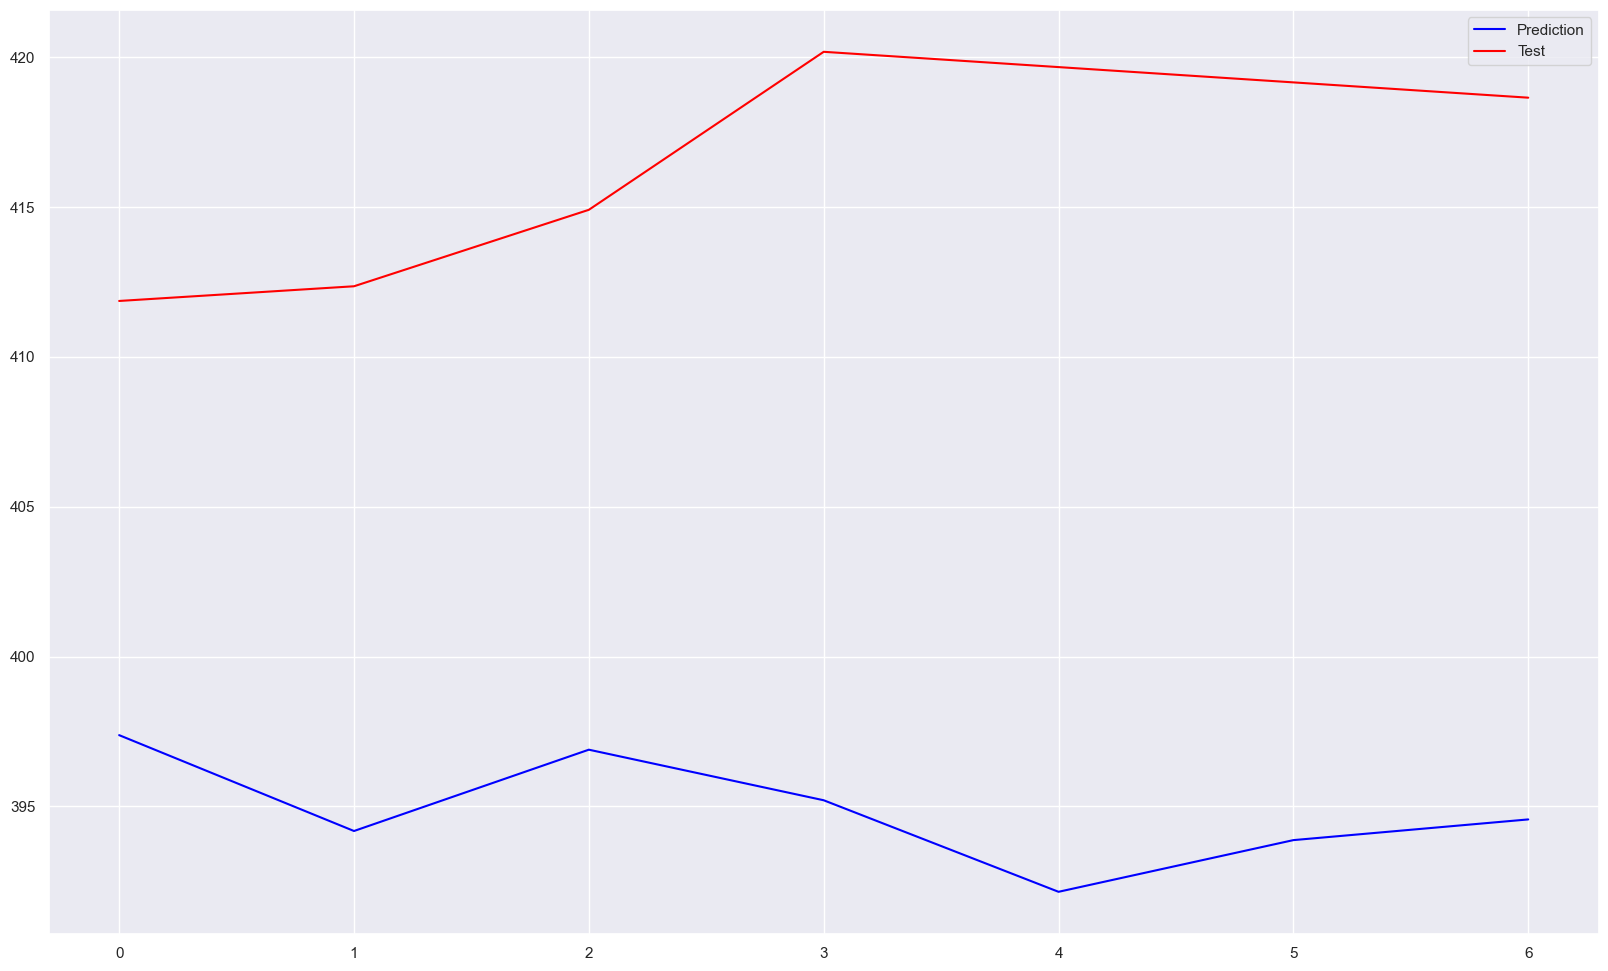

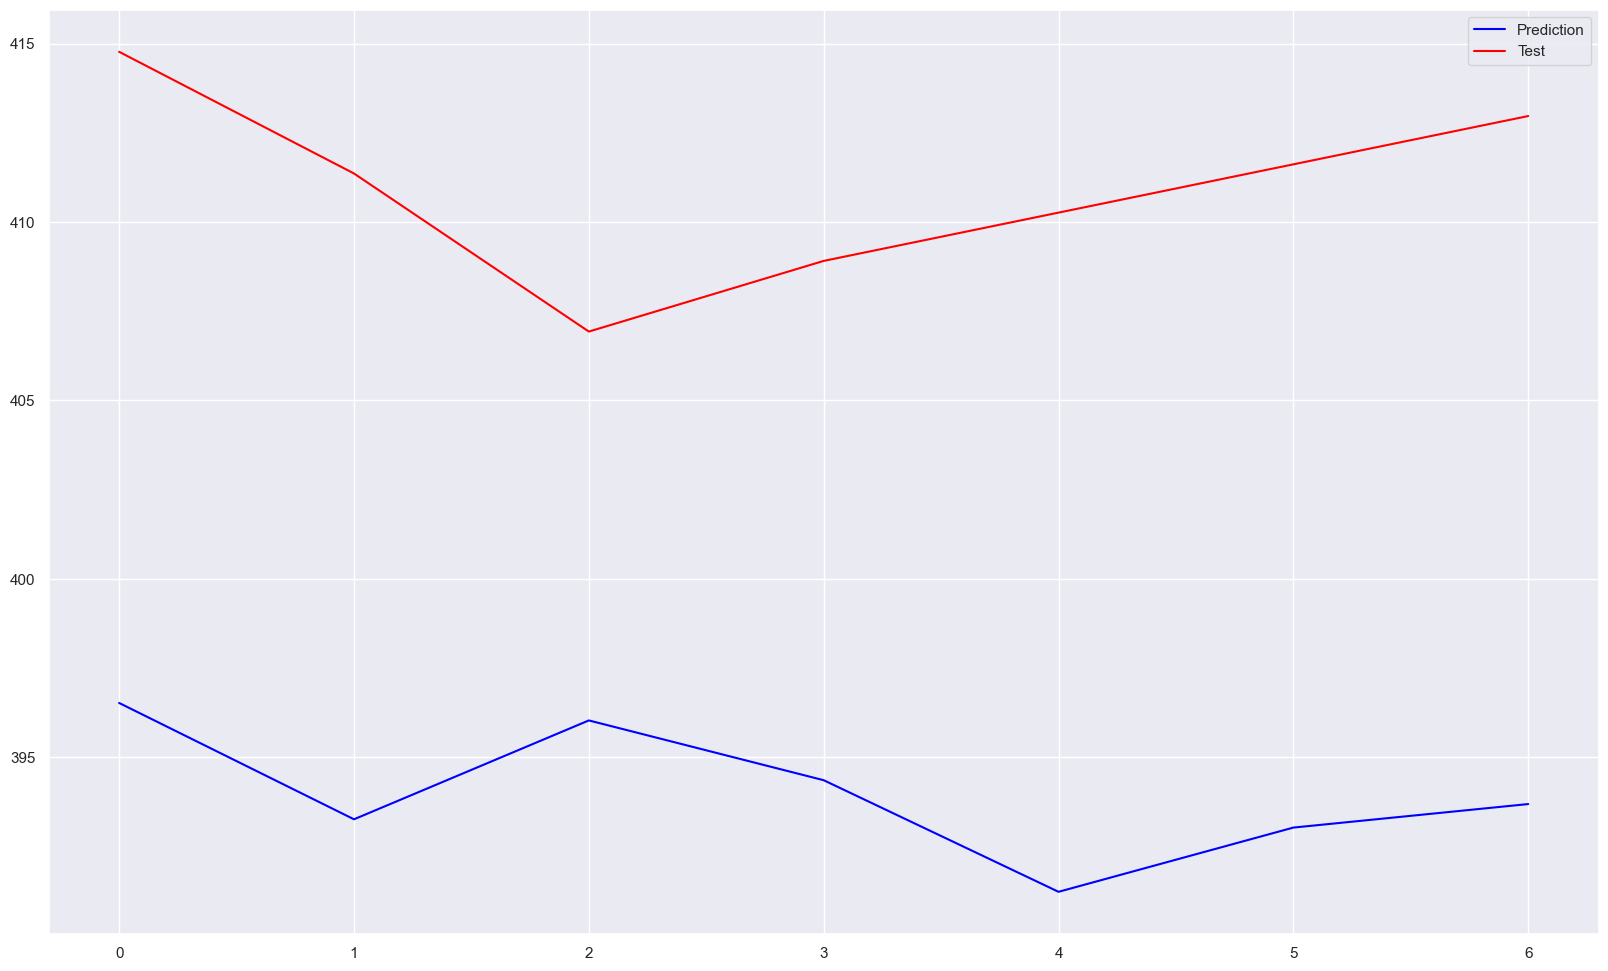

In [65]:
for i in range(y_pred.shape[0]):
    fig = plt.gcf(); fig.set_size_inches(20, 12);
    plt.plot(y_pred[i, :], c="blue", label="Prediction")
    plt.plot(y_test[i, :], c="red", label="Test")
#     plt.ylim(0, 430)
    plt.legend(loc='upper right')
    plt.show();

In [30]:
dl_error = np.mean(abs(y_pred - y_test))

In [31]:
base_error = np.mean(abs((df_main[['SPY_open']]-df_main[['SPY_open']].shift(7)).dropna()))[0]

/Users/Dayus/.pyenv/versions/3.10.6/envs/sandbox/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [32]:
print(
    f"DL model predicts with an average error of        ${round(dl_error, 2)}"
    "\n"
    f"2 Weeks before predicts with an average error of  ${round(base_error, 2)}"
)

DL model predicts with an average error of        $18.35
2 Weeks before predicts with an average error of  $4.63


# plot_loss_metrics

In [33]:
history.history

{'loss': [343.1092529296875,
  307.1483459472656,
  273.9255065917969,
  243.27749633789062,
  215.14463806152344,
  189.45957946777344,
  166.1295928955078,
  145.018310546875,
  126.01240539550781,
  108.98902130126953,
  93.83451843261719,
  80.40737915039062,
  68.57188415527344,
  58.2076530456543,
  49.1717414855957,
  41.337615966796875,
  34.58077621459961,
  28.781076431274414,
  23.83134651184082,
  19.62977409362793,
  16.084667205810547,
  13.111175537109375,
  10.626045227050781,
  8.564096450805664,
  6.864650249481201,
  5.476893424987793,
  4.345413684844971,
  3.4281392097473145,
  2.688525438308716,
  2.1006321907043457],
 'mae': [0.15427908301353455,
  0.026719747111201286,
  0.025368425995111465,
  0.024570202454924583,
  0.023921925574541092,
  0.02345893532037735,
  0.023074619472026825,
  0.02268327958881855,
  0.022408660501241684,
  0.022165970876812935,
  0.021915312856435776,
  0.02172372117638588,
  0.02149161696434021,
  0.021359654143452644,
  0.0211539342

In [34]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: LOSS --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('LOSS')
    ax[0].set_xlabel('EPOCH')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS: MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('Mean Absolute Error')
    ax[1].set_ylabel('LOSS')
    ax[1].set_xlabel('EPOCH')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

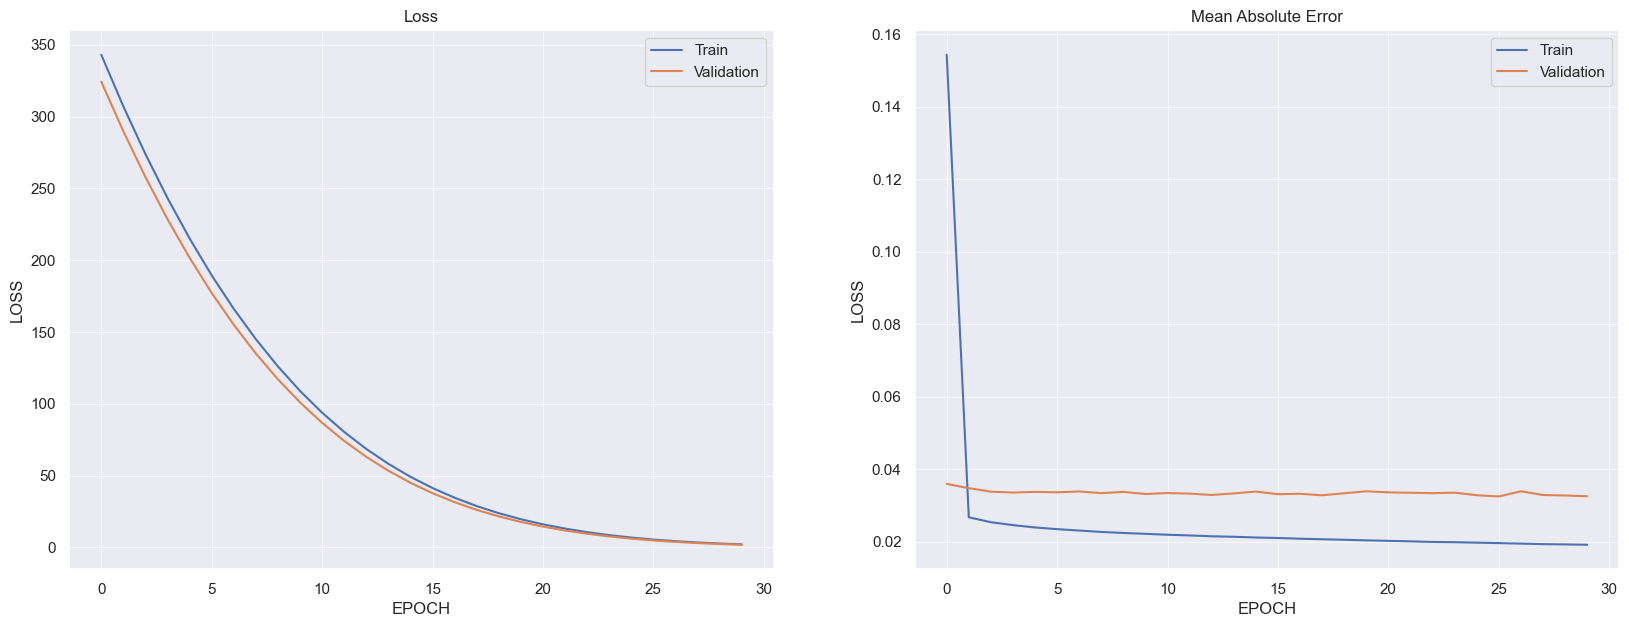

In [35]:
plot_history(history);